In [1]:
from numpy import *
from time import sleep
import matplotlib.pyplot as plt
import pandas as pd 

/Users/sivber/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return array(dataMat),array(labelMat)
class smoSVM:
    def __init__(self,xMatIn,yMatIn,C,toler,kTup,maxIter):
        self.X = mat(xMatIn)
        self.Y = mat(yMatIn).transpose()
        self.C = C
        self.tol = toler
        self.m = shape(xMatIn)[0]
        self.n = shape(xMatIn)[1]
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0
        self.eCache = mat(zeros((self.m,2)))
        self.K = mat(zeros((self.m,self.m)))
        self.kTup = kTup
        self.maxIter = maxIter
        self.w = mat(zeros((self.n,1)))
        for i in range(self.m):
            self.K[:,i] = self.kernelTrans(i)
            
    def selectJrand(self,i):
        j=i #we want to select any J not equal to i
        while (j==i):
            j = int(random.uniform(0,self.m))
        return j

    def clipAlpha(self,aj,H,L):
        if aj > H: 
            aj = H
        if L > aj:
            aj = L
        return aj
    def calcEk(self,k):
        fxk = float(multiply(self.alphas,self.Y).T*(self.X*self.X[k,:].T)) + self.b
        Ek = fxk - float(self.Y[k])
        return Ek

    #选取Ei-Ej绝对值最大的j
    def selectJ(self,i,Ei):
        maxK = -1; maxDeltaE = 0; Ej = 0
        #第一列为标志该值是否有效，第二列才为误差值
        self.eCache[i] = [1,Ei]
        #nonzero返回不为0的坐标,[0]为行坐标，[1]为列坐标，[i]为第i纬的坐标
        validEcacheList = nonzero(self.eCache[:,0].A)[0]
        if (len(validEcacheList)) > 1:
            for k in validEcacheList:   
                if k == i: continue 
                Ek = self.calcEk(k)
                deltaE = abs(Ei - Ek)
                if (deltaE > maxDeltaE):
                    maxK = k; maxDeltaE = deltaE; Ej = Ek
            return maxK, Ej
        else:  
            j = self.selectJrand(i)
            Ej = self.calcEk(j)
        return j, Ej
    
    def updateEk(self, k):
        Ek = self.calcEk( k)
        self.eCache[k] = [1,Ek]
        
    def innerL(self,i):
        Ei = self.calcEk(i)
        #KTT : 0 <= alpha <= C toler为容错参数，当超过容错参数同时alpha在约束条件内才继续优化alpha，
        #统计学习方法.李航 p113 支持向量部分
        #Y_train[i]*Ei < -toler表示i被误分类到另外一侧，且在间隔之外，如果alpha<C那么alpha应该增大
        #Y_train[i]*Ei > toler表示i被正分类了，且在间隔之外,如果alpha>0那么alpha应该缩小
        if ((self.Y[i]*Ei<-self.tol) and (self.alphas[i] < self.C)) or ((self.Y[i]*Ei>self.tol) and (self.alphas[i] >0)):
            #计算误差
            j,Ej = self.selectJ(i,Ei)
            alphaIold = self.alphas[i].copy();alphaJold = self.alphas[j].copy();
            #由KTT:sum(alphas*y) = 0
            #当i与j的y同号时相当于alphas[i] + alphas[j] = A(常数) 
            #异号时相当于alphas[i] - alphas[j] = A
            #同时必须满足 0 <= alpha <= C 
            #则分别求出上下界L H 如果上下界相同，则alpha处于边界 直接跳过
            if(self.Y[i]!=self.Y[j]):
                L = max(0,self.Y[j]-self.Y[i])
                H = min(self.C,self.C+self.Y[j]-self.Y[i])
            else:
                L = max(0,-self.C+self.Y[j]+self.Y[i])
                H = min(self.C,self.Y[j]+self.Y[i])
            if L==H: print "L==H"; return 0
            #由sum(y[i]*alpha[i]) = 0 将alpha[j]由alpha[i]表示带入目标函数 可以得到alpha[2]的一元二次方程，求导使其为0可以得到极值点
            #最终alpha[j]=alpha[j]_old + y[j](Ei-Ej)/(K11+K22-2K12) K11 = (X[i].X[j])
            #这里eta为2K12 - K11 - K22
            eta = 2.0*self.K[i,j] - self.K[i,i] - self.K[j,j]
            if eta >= 0: print "eta>=0"; return 0
            self.alphas[j] -= self.Y[j]*(Ei-Ej)/eta
            self.alphas[j] = self.clipAlpha(self.alphas[j],H,L)
            self.updateEk(j)
            if (abs(self.alphas[j] - alphaJold) < 0.00001): print "j not moving enough"; return 0
            self.alphas[i] += self.Y[j]*self.Y[i]*(alphaJold - self.alphas[j])#update i by the same amount as j
            self.updateEk(i) #added this for the Ecache                    #the update is in the oppostie direction
            b1 = self.b - Ei- self.Y[i]*(self.alphas[i]-alphaIold)*self.K[i,i] - self.Y[j]*(self.alphas[j]-alphaJold)*self.K[i,j]
            b2 = self.b - Ej- self.Y[i]*(self.alphas[i]-alphaIold)*self.K[i,j]- self.Y[j]*(self.alphas[j]-alphaJold)*self.K[j,j]
            if (0 < self.alphas[i]) and (self.C > self.alphas[i]): self.b = b1
            elif (0 < self.alphas[j]) and (self.C > self.alphas[j]): self.b = b2
            else: self.b = (b1 + b2)/2.0
            return 1
        else: return 0
    def smoP(self):    #full Platt SMO
        iter = 0
        entireSet = True; alphaPairsChanged = 0
        while (iter < self.maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
            alphaPairsChanged = 0
            if entireSet:   
                for i in range(self.m):        
                    alphaPairsChanged += self.innerL(i)
#                     print "fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged)
                iter += 1
            else:
                #取0,C之间的alpha
                nonBoundIs = nonzero((self.alphas.A > 0) * (self.alphas.A < self.C))[0]
                for i in nonBoundIs:
                    alphaPairsChanged += self.innerL(i)
#                     print "non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged)
                iter += 1
            if entireSet: entireSet = False 
            elif (alphaPairsChanged == 0): entireSet = True  
            print "iteration number: %d" % iter
        return 0
    def calcWs(self):
        for i in range(self.m):
            self.w += multiply(self.alphas[i]*self.Y[i],self.X[i,:].T)
        return self.w
    def kernelTrans(self,i): #calc the kernel or transform data to a higher dimensional space
        m,n = shape(self.X)
        K = mat(zeros((m,1)))
        if self.kTup[0]=='lin': K = self.X * self.X[i,:].T   #linear kernel
        elif self.kTup[0]=='rbf':
            for j in range(m):
                deltaRow = self.X[j,:] - self.X[i,:]
                K[j] = deltaRow*deltaRow.T
            K = exp(K/(-1*self.kTup[1]**2)) #divide in NumPy is element-wise not matrix like Matlab
        else: raise NameError('Houston We Have a Problem -- \
        That Kernel is not recognized')
        return K
    def predict(self,dataIn):
        if dataIn.shape[1] != self.X.shape[1]:
            print('数据有误')
            return 0
        w = self.calcWs()
        y = mat(dataIn)*mat(w) + self.b
        return array(y)
    def predictAndDraw(self,dataIn):
        predictResult = self.predict(array(dataIn))
        neg = dataIn[where(predictResult[:,0]<=0)]
        pos = dataIn[where(predictResult[:,0]>=0)]

        plt.scatter(neg[:,0],neg[:,1],c= "red")
        plt.scatter(pos[:,0],pos[:,1],c= "blue")
        x = array(linspace(3, 6, 100))
        y = (-self.b-self.w[0]*x)/self.w[1]
        plt.plot(x,y.T)

        #绿色的为支持向量
#         alphas = array(self.alphas)
#         plt.scatter(dataIn[where(alphas[:,0] > 0)][:,0],dataIn[where(alphas[:,0] > 0)][:,1],c="green",marker="D")
        plt.show()

In [3]:
#0<=spl<=1
def splitData(data,label,spl):
    if spl > 1:spl=1
    if spl < 0:spl=0
    msk = random.rand(len(data)) < spl
    trainData = data[msk]
    trainLabel = label[msk]
    
    testData = data[~msk]
    testLabel = label[~msk]
    return trainData,trainLabel,testData,testLabel

In [4]:
data,label = loadDataSet("testSet.txt")
data = array(data);label = array(label)
trainData,trainLabel,testData,testLabel = splitData(data=data,label=label,spl=0.6)

In [5]:
model = smoSVM(xMatIn=trainData,yMatIn=trainLabel,C=0.6,toler=0.001,kTup=('lin',1),maxIter=40)

In [6]:
from time import time
start = time()
model.smoP()
stop = time()
print(str(stop-start) + "秒")


iteration number: 1
iteration number: 2
iteration number: 3
iteration number: 4
iteration number: 5
iteration number: 6
iteration number: 7
iteration number: 8
iteration number: 9
iteration number: 10
iteration number: 11
iteration number: 12
iteration number: 13
iteration number: 14
iteration number: 15
iteration number: 16
iteration number: 17
iteration number: 18
iteration number: 19
iteration number: 20
iteration number: 21
iteration number: 22
iteration number: 23
iteration number: 24
iteration number: 25
iteration number: 26
iteration number: 27
iteration number: 28
iteration number: 29
iteration number: 30
iteration number: 31
iteration number: 32
iteration number: 33
iteration number: 34
iteration number: 35
iteration number: 36
iteration number: 37
iteration number: 38
iteration number: 39
iteration number: 40
0.138741970062秒


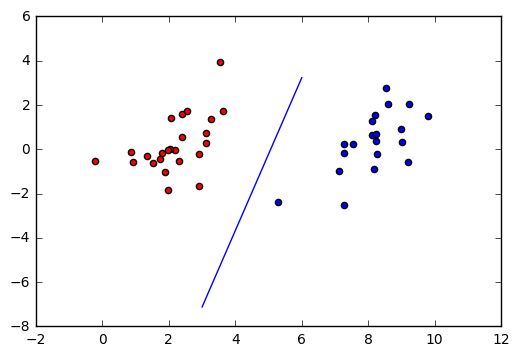

In [7]:
model.predictAndDraw(testData)

In [31]:
testSetRBFData,testSetRBFLabel = loadDataSet("testSetRBF.txt")

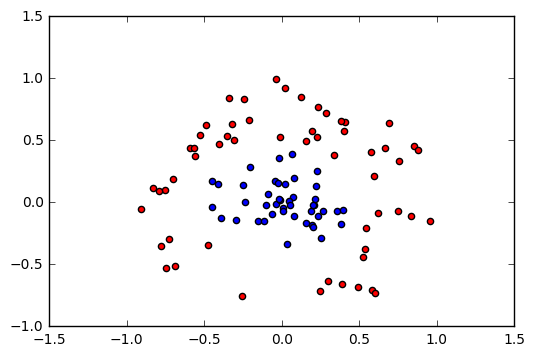

In [32]:
neg = testSetRBFData[where(testSetRBFLabel<0)]
pos = testSetRBFData[where(testSetRBFLabel>0)]

plt.scatter(neg[:,0],neg[:,1],c= "red")
plt.scatter(pos[:,0],pos[:,1],c= "blue")
plt.show()

In [33]:
trainSetData,trainSetLabel,testSetData,testSetLabel = splitData(testSetRBFData,testSetRBFLabel,0.6)

In [34]:
model2 = smoSVM(xMatIn=trainSetData,yMatIn=trainSetLabel,C=0.6,toler=0.001,kTup=('rbf',1.2),maxIter=100)

In [35]:
model2.smoP()

j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
iteration number: 1
iteration number: 2
j not moving enough
j not moving enough
j not moving enough


0

In [36]:
testSetPrediction = model2.predict(testSetData)

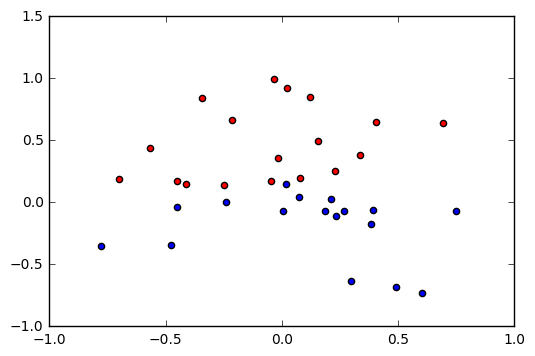

In [37]:

neg = testSetData[where(testSetPrediction[:,0]<0)]
pos = testSetData[where(testSetPrediction[:,0]>0)]

plt.scatter(neg[:,0],neg[:,1],c= "red")
plt.scatter(pos[:,0],pos[:,1],c= "blue")
plt.show()

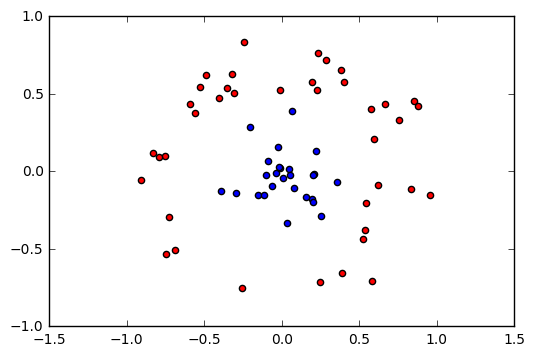

In [38]:
neg = trainSetData[where(trainSetLabel<0)]
pos = trainSetData[where(trainSetLabel>0)]

plt.scatter(neg[:,0],neg[:,1],c= "red")
plt.scatter(pos[:,0],pos[:,1],c= "blue")
plt.show()